In [1]:
pwd

'/Users/in-divye.singh/Documents/Projects/MIC_predictor/notebooks/classifier'

In [2]:
cd ../../

/Users/in-divye.singh/Documents/Projects/MIC_predictor


In [3]:
from notebooks.utils import *

In [4]:
import biovec
import numpy as np
import pandas as pd
from itertools import chain
from collections import Counter

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from sklearn.svm import SVC
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, matthews_corrcoef
from sklearn.metrics import classification_report, confusion_matrix, make_scorer
from sklearn.model_selection import train_test_split

In [7]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [8]:
avp_ic50 = pd.read_csv("data/raw/AVP-IC50Pred_train.csv")
ha_avp = pd.read_csv("data/raw/HA_AVP.csv")

df = pd.concat([avp_ic50[['Sequence','MIC']], ha_avp], axis=0).drop_duplicates(['Sequence']).reset_index(drop=True)
df = sequence_filtering(df)

In [9]:
df['lessthan5'] = df['MIC'].apply(lambda mic: 1 if mic <= 5 else 0)

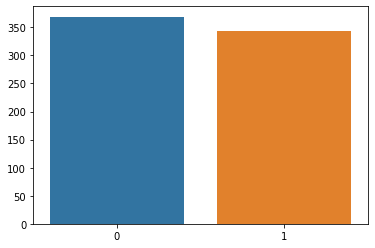

In [10]:
count = dict(Counter(df['lessthan5']))
sns.barplot(x = [str(k) for k in count.keys()], y=[float(v) for v in count.values()])

In [11]:
def get_score(y_true, y_pred):
    print(f'Accuracy: {round(accuracy_score(y_true, y_pred), 4)}')
    print(f'F1-score: {round(f1_score(y_true, y_pred), 4)}')
    print(f'AUROC: {round(roc_auc_score(y_true, y_pred), 4)}')
    print(f'MCC: {round(matthews_corrcoef(y_true, y_pred), 4)}')
    print(classification_report(y_test, y_pred))

### ProtVec

In [12]:
############# Prot2Vec #############
uniprot_embedding = biovec.models.load_protvec("data/embeddings/uniprot__kmer_3_contextWindow_10_vector_100_reduction_None")

avg_vectors = convert_sequences_to_avg_vectors(df['Sequence'], uniprot_embedding)
avg_vectors = avg_vectors.reset_index(drop=True)

/Users/in-divye.singh/anaconda3/envs/life-science/lib/python3.6/site-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
Creating vectors: 100%|██████████| 712/712 [00:00<00:00, 1056.32sequence/s]


In [13]:
X_train, X_test, y_train, y_test = train_test_split(avg_vectors, df['lessthan5'], test_size=0.2, random_state=42)

In [14]:
X_train.shape, X_test.shape

((569, 100), (143, 100))

In [15]:
clf = SVC(class_weight='balanced')

In [20]:
clf.fit(X_train, y_train)

SVC(class_weight='balanced')

In [21]:
y_pred = clf.predict(X_test)

In [22]:
get_score(y_test, y_pred)

Accuracy: 0.7273
F1-score: 0.6829
AUROC: 0.7235
MCC: 0.4443
              precision    recall  f1-score   support

           0       0.78      0.75      0.76        83
           1       0.67      0.70      0.68        60

    accuracy                           0.73       143
   macro avg       0.72      0.72      0.72       143
weighted avg       0.73      0.73      0.73       143



In [23]:
mcc_scorer = make_scorer(matthews_corrcoef)

In [101]:
param_grid = {'C':[0.01,0.1,1,100,1000],
              'kernel': ['rbf','poly','sigmoid','linear'],
              'degree': [1,2,3,4,5,6],
              'gamma': ['scale', 'auto', 100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
              'coef0': [0.0,0.5,1,1.5,2,2.5,3],
              'class_weight': ['balanced', None]
             }
# Create a based model
clf = SVC()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 1, scoring=mcc_scorer)

In [102]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 15120 candidates, totalling 75600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


KeyboardInterrupt: 

In [51]:
grid_search.best_params_

{'C': 100, 'class_weight': 'balanced', 'gamma': 100, 'kernel': 'rbf'}

In [52]:
best_grid = grid_search.best_estimator_

In [53]:
y_pred = best_grid.predict(X_test)

In [54]:
get_score(y_test, y_pred)

Accuracy: 0.6993
F1-score: 0.6055
AUROC: 0.6786
MCC: 0.3714
              precision    recall  f1-score   support

           0       0.71      0.81      0.76        83
           1       0.67      0.55      0.61        60

    accuracy                           0.70       143
   macro avg       0.69      0.68      0.68       143
weighted avg       0.70      0.70      0.69       143



In [56]:
grid_search.best_score_

0.48177106352327825

### ProtVec + AA frequence

In [ ]:
aa_freq = reduce_by_kmer_frequency(df)

In [ ]:
protvec_aa_freq = pd.concat([avg_vectors, aa_freq], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(protvec_aa_freq, df['lessthan5'], test_size=0.2, random_state=42)

In [ ]:
X_train.shape, X_test.shape

In [49]:
# Create the parameter grid based on the results of random search 
param_grid = {'C':[0.01,0.1,1,100,1000],
              'kernel': ['rbf','poly','sigmoid','linear'],
              #'degree': [1,2,3,4,5,6],
              'gamma': ['scale', 'auto', 100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
              #'coef0': [0.0,0.5,1,1.5,2,2.5,3],
              'class_weight': ['balanced', None]
             }
# Create a based model
clf = SVC()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
                          cv = 10, n_jobs = -1, verbose = 1, scoring=mcc_scorer)

In [50]:
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 90 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:    5.1s finished


GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 100, 1000],
                         'class_weight': ['balanced', None],
                         'gamma': ['scale', 'auto', 100, 10, 1, 0.1, 0.01,
                                   0.001, 0.0001],
                         'kernel': ['rbf']},
             scoring=make_scorer(matthews_corrcoef), verbose=1)

In [51]:
grid_search.best_params_

{'C': 100, 'class_weight': 'balanced', 'gamma': 100, 'kernel': 'rbf'}

In [52]:
best_grid = grid_search.best_estimator_

In [53]:
y_pred = best_grid.predict(X_test)

In [54]:
get_score(y_test, y_pred)

Accuracy: 0.6993
F1-score: 0.6055
AUROC: 0.6786
MCC: 0.3714
              precision    recall  f1-score   support

           0       0.71      0.81      0.76        83
           1       0.67      0.55      0.61        60

    accuracy                           0.70       143
   macro avg       0.69      0.68      0.68       143
weighted avg       0.70      0.70      0.69       143



### ProtVec + dipep freq

In [ ]:
dipep_freq = reduce_by_kmer_frequency(df, kmer=2)

In [ ]:
protvec_dipep_freq = pd.concat([avg_vectors, dipep_freq], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(protvec_dipep_freq, df['lessthan5'], test_size=0.2, random_state=42)

In [ ]:
X_train.shape, X_test.shape

In [49]:
# Create the parameter grid based on the results of random search 
param_grid = {'C':[0.01,0.1,1,100,1000],
              'kernel': ['rbf','poly','sigmoid','linear'],
              'degree': [1,2,3,4,5,6],
              'gamma': ['scale', 'auto', 100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
              'coef0': [0.0,0.5,1,1.5,2,2.5,3],
              'class_weight': ['balanced', None]
             }
# Create a based model
clf = SVC()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
                          cv = 10, n_jobs = -1, verbose = 1, scoring=mcc_scorer)

In [50]:
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 90 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:    5.1s finished


GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 100, 1000],
                         'class_weight': ['balanced', None],
                         'gamma': ['scale', 'auto', 100, 10, 1, 0.1, 0.01,
                                   0.001, 0.0001],
                         'kernel': ['rbf']},
             scoring=make_scorer(matthews_corrcoef), verbose=1)

In [51]:
grid_search.best_params_

{'C': 100, 'class_weight': 'balanced', 'gamma': 100, 'kernel': 'rbf'}

In [52]:
best_grid = grid_search.best_estimator_

In [53]:
y_pred = best_grid.predict(X_test)

In [54]:
get_score(y_test, y_pred)

Accuracy: 0.6993
F1-score: 0.6055
AUROC: 0.6786
MCC: 0.3714
              precision    recall  f1-score   support

           0       0.71      0.81      0.76        83
           1       0.67      0.55      0.61        60

    accuracy                           0.70       143
   macro avg       0.69      0.68      0.68       143
weighted avg       0.70      0.70      0.69       143



### ProtVec + AA frequence + Dipeptide frequency

In [ ]:
protvec_aa_dipep = pd.concat([avg_vectors, aa_freq, dipep_freq], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(protvec_aa_dipep, df['lessthan5'], test_size=0.2, random_state=42)

In [ ]:
X_train.shape, X_test.shape

In [49]:
# Create the parameter grid based on the results of random search 
param_grid = {'C':[0.01,0.1,1,100,1000],
              'kernel': ['rbf','poly','sigmoid','linear'],
              'degree': [1,2,3,4,5,6],
              'gamma': ['scale', 'auto', 100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
              'coef0': [0.0,0.5,1,1.5,2,2.5,3],
              'class_weight': ['balanced', None]
             }
# Create a based model
clf = SVC()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
                          cv = 10, n_jobs = -1, verbose = 1, scoring=mcc_scorer)

In [50]:
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 90 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:    5.1s finished


GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 100, 1000],
                         'class_weight': ['balanced', None],
                         'gamma': ['scale', 'auto', 100, 10, 1, 0.1, 0.01,
                                   0.001, 0.0001],
                         'kernel': ['rbf']},
             scoring=make_scorer(matthews_corrcoef), verbose=1)

In [51]:
grid_search.best_params_

{'C': 100, 'class_weight': 'balanced', 'gamma': 100, 'kernel': 'rbf'}

In [52]:
best_grid = grid_search.best_estimator_

In [53]:
y_pred = best_grid.predict(X_test)

In [54]:
get_score(y_test, y_pred)

Accuracy: 0.6993
F1-score: 0.6055
AUROC: 0.6786
MCC: 0.3714
              precision    recall  f1-score   support

           0       0.71      0.81      0.76        83
           1       0.67      0.55      0.61        60

    accuracy                           0.70       143
   macro avg       0.69      0.68      0.68       143
weighted avg       0.70      0.70      0.69       143



In [72]:
shannon_entropy = pd.read_csv("data/pfeature/ha_avp_ic50_shannon_entropy.csv")
residue_repeats = pd.read_csv("data/pfeature/ha_avp_ic50_residue_repeat.csv")

In [84]:
import json

In [92]:
with open("test.csv", "w") as f:
    f.write(", ".join(["0","1", "2", "3", "4", "5"])+"\n")

In [93]:
for i in range(5):
    with open("test.csv", "a") as f:
        f.write('"'+str(grid_search.best_params_)+'", '+", ".join(map(lambda x:str(i*x), [2,3,4,5,6]))+"\n")

In [98]:
for k,v in grid_search.best_params_.items():
    print(k, v)

C 100
class_weight balanced
gamma 100
kernel rbf


In [107]:
pd.read_csv("data/pfeature/ha_avp_ic50_sec_struct.csv")

,ID,PCP_SS_HE,PCP_SS_ST,PCP_SA_BU,PCP_SA_EX,PCP_SA_IN
0,Seq_1,0.471,0.118,0.412,0.353,0.059
1,Seq_2,0.750,0.250,0.333,0.083,0.333
2,Seq_3,0.250,0.125,0.250,0.500,0.250
3,Seq_4,0.273,0.182,0.364,0.455,0.091
4,Seq_5,0.471,0.118,0.412,0.294,0.118
...,...,...,...,...,...,...
707,Seq_708,0.300,0.433,0.600,0.233,0.133
708,Seq_709,0.273,0.500,0.273,0.273,0.409
709,Seq_710,0.556,0.222,0.361,0.444,0.194
710,Seq_711,0.255,0.191,0.383,0.511,0.255


In [110]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

In [108]:
params = ['molecular_weight', 'aromaticity', 'instability_index',
          'isoelectric_point', 'helix', 'turn', 'sheet', 'with_reduced_cysteines',
          'with_disulfid_bridges', 'gravy', 'net_charge_at_pH7point4']

In [111]:
prop = []
for seq in df.Sequence:
    X = ProteinAnalysis(seq)
    molecular_weight = X.molecular_weight()
    aromaticity = X.aromaticity()
    instability_index = X.instability_index()
    isoelectric_point = X.isoelectric_point()
    sec_struc = X.secondary_structure_fraction()
    helix = sec_struc[0]
    turn = sec_struc[1]
    sheet = sec_struc[2]
    epsilon_prot = X.molar_extinction_coefficient()
    with_reduced_cysteines = epsilon_prot[0]
    with_disulfid_bridges = epsilon_prot[1]
    gravy = X.gravy() # hydrophobicity related
    # flexibility = X.flexibility()
    # X.protein_scale()
    net_charge_at_pH7point4 = X.charge_at_pH(7.4)

    prop.append([molecular_weight, aromaticity, instability_index, isoelectric_point, helix, turn, sheet,
                 with_reduced_cysteines, with_disulfid_bridges, gravy, net_charge_at_pH7point4])
prop = pd.DataFrame(prop, columns=params)

In [112]:
prop

,molecular_weight,aromaticity,instability_index,isoelectric_point,helix,turn,sheet,with_reduced_cysteines,with_disulfid_bridges,gravy,net_charge_at_pH7point4
0,1850.9960,0.000000,24.817647,11.999968,0.117647,0.352941,0.117647,0,0,-1.547059,2.609418
1,1525.8875,0.000000,36.466667,11.999968,0.250000,0.000000,0.333333,0,0,-0.208333,2.594004
2,871.8950,0.000000,48.687500,6.087706,0.125000,0.500000,0.000000,0,0,-1.700000,-0.440856
3,1211.2883,0.000000,-11.454545,9.598972,0.181818,0.454545,0.000000,0,0,-1.545455,0.559118
4,1837.9973,0.000000,56.905882,11.999968,0.117647,0.352941,0.117647,0,0,-1.370588,2.609418
...,...,...,...,...,...,...,...,...,...,...,...
707,3336.9618,0.100000,-1.326667,9.408790,0.233333,0.266667,0.066667,5500,5750,-0.066667,4.466476
708,2889.2103,0.272727,33.700000,9.625146,0.318182,0.181818,0.000000,15470,15470,-1.486364,2.559925
709,4450.8237,0.138889,62.650000,4.300688,0.361111,0.194444,0.361111,17990,17990,-0.875000,-5.406266
710,5189.4931,0.127660,18.168085,4.443127,0.234043,0.446809,0.148936,11000,11000,-1.004255,-4.370952


In [118]:
import seaborn as sns

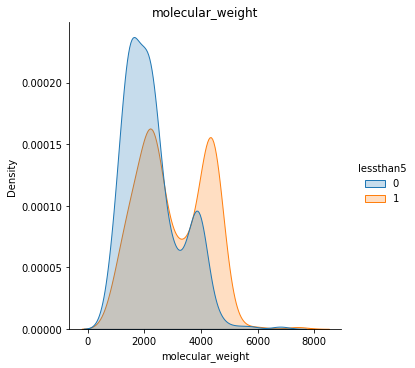

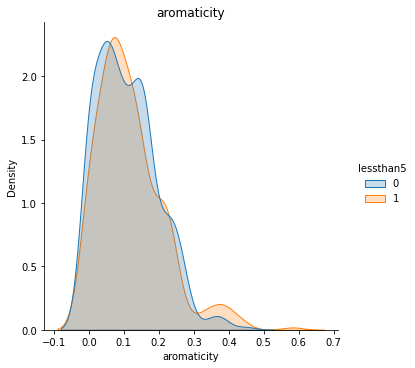

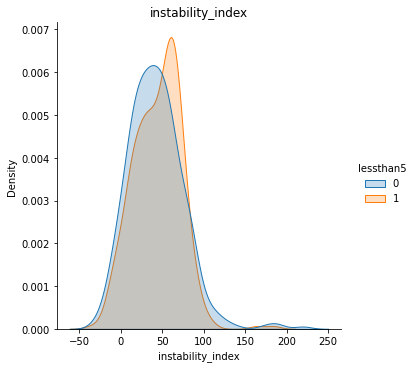

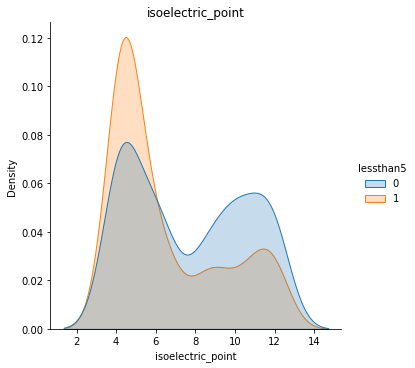

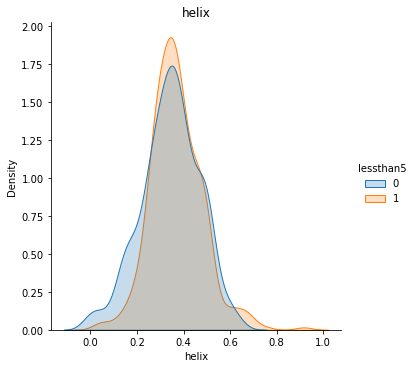

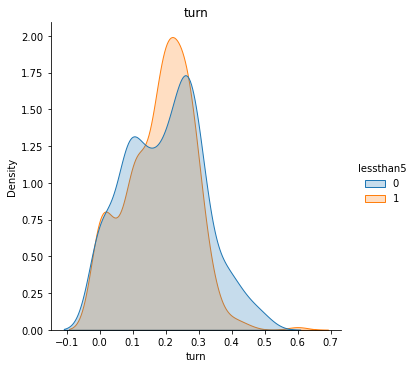

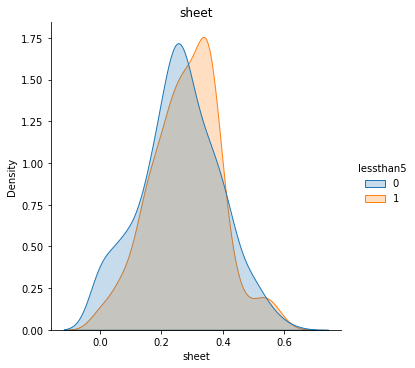

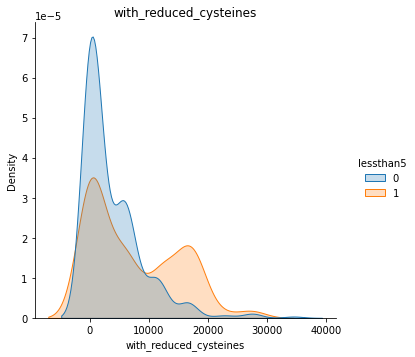

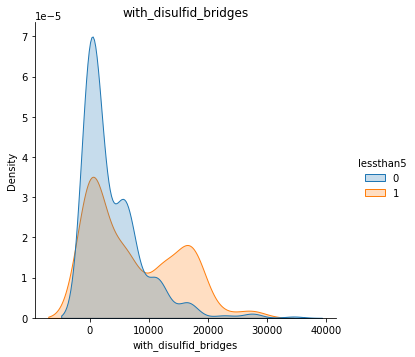

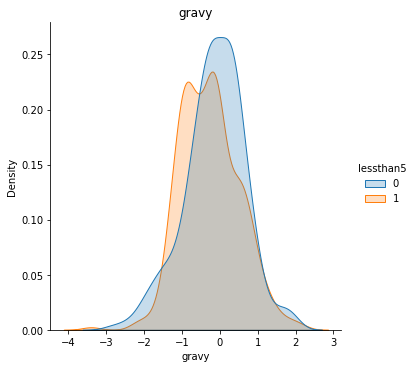

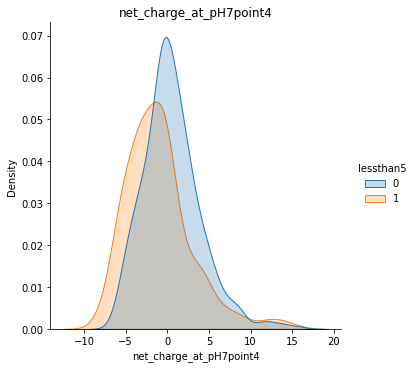

In [123]:
for feature in prop.columns:
    sns.displot(prop, x=feature, hue=df['lessthan5'], kind="kde", fill=True)
    plt.title(feature)